<a href="https://colab.research.google.com/github/mmtaha/Ciencia-de-dados---Projeto-Detectando_Fraudes_em_Transferncias/blob/main/ciencia_de_dados_detectando_fraudes_em_transferncias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencia De Dados - Detectando Fraudes Em Transfer√™ncias Banc√°rias

## Qual o Problema de Neg√≥cio

Esse conjunto de dados fict√≠cio possui transa√ß√µes de transfer√™ncias entre contas de uma mesma Institui√ß√£o Financeira. S√£o mais de 200 mil registros de transfer√™ncias, sendo 490 Fraudulentas, ou seja, n√£o foram realizadas pelo dono da conta corrente. Temos 28 vari√°veis explicativas e a vari√°vel Classe √© o Target e assume o valor 1 em caso de fraude e 0 em caso contr√°rio.

In [88]:
!pip install matplotlib xgboost lightgbm kaggle seaborn numpy kagglehub scipy

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configura√ß√µes de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Carregando o dataset
file_path = "transferencias.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "kelvimimperial/deteco-de-fraudes-em-cartes-de-credito",
    file_path,
)

print(f"Dimens√µes do dataset: {df.shape[0]} linhas √ó {df.shape[1]} colunas")

Using Colab cache for faster access to the 'deteco-de-fraudes-em-cartes-de-credito' dataset.
Dimens√µes do dataset: 284807 linhas √ó 31 colunas


#AN√ÅLISE EXPLORAT√ìRIA VISUAL

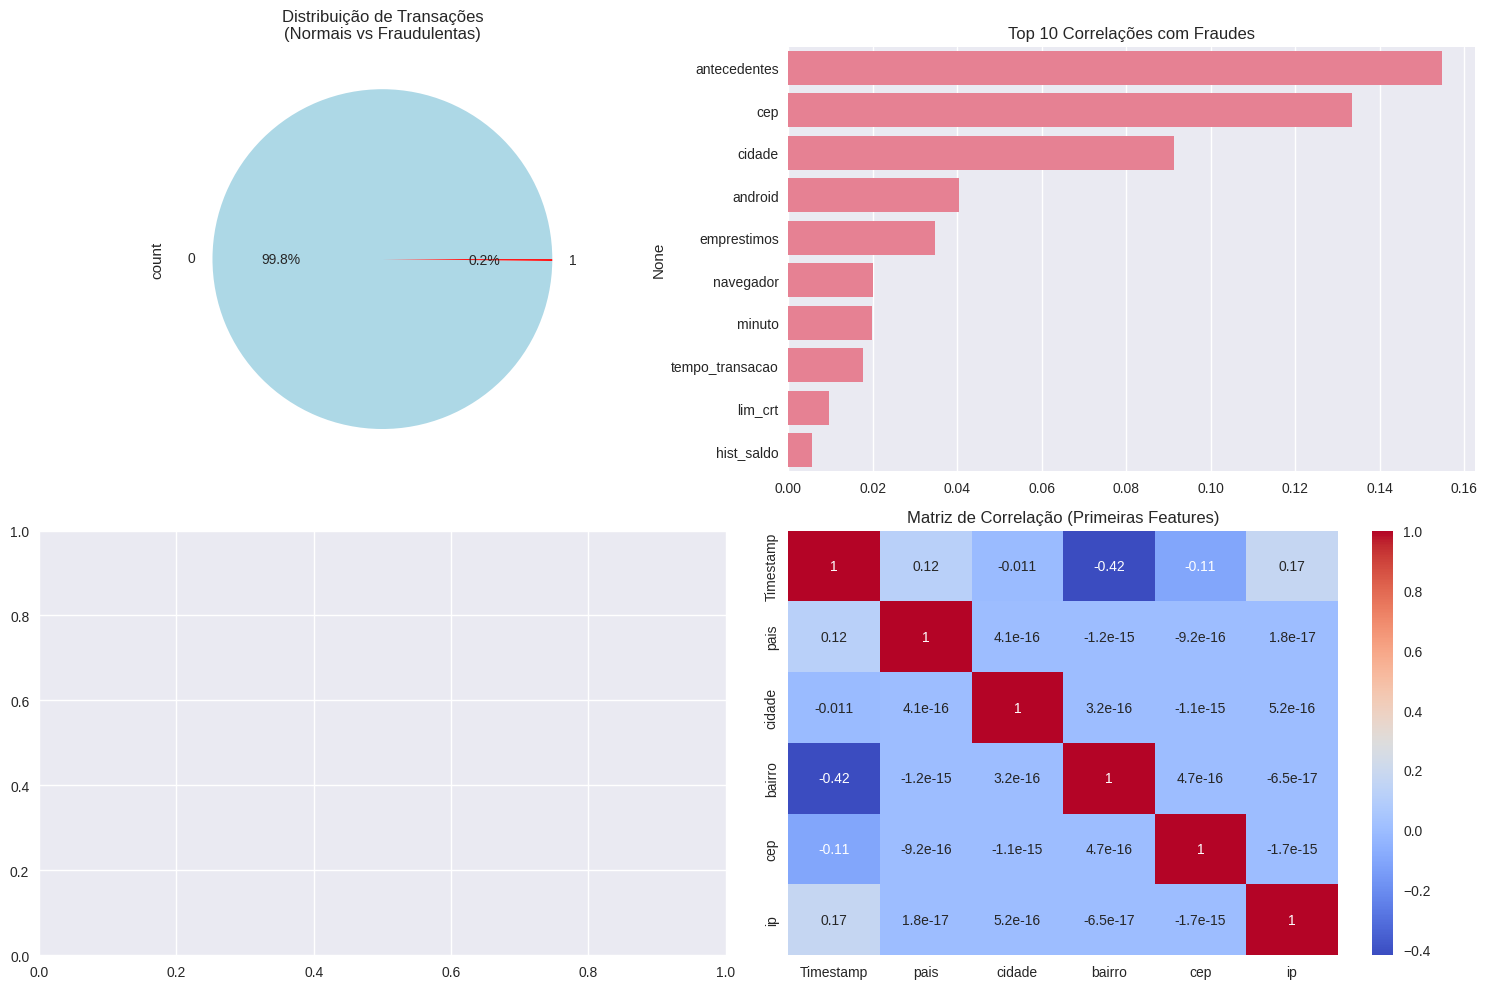

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gr√°fico 1: Distribui√ß√£o do target
df['Target'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0,0], colors=['lightblue', 'red'])
axes[0,0].set_title('Distribui√ß√£o de Transa√ß√µes\n(Normais vs Fraudulentas)')

# Gr√°fico 2: Correla√ß√µes com o target
correlations = df.corr()['Target'].sort_values(ascending=False).drop('Target')
top_correlations = correlations.head(10)
sns.barplot(x=top_correlations.values, y=top_correlations.index, ax=axes[0,1])
axes[0,1].set_title('Top 10 Correla√ß√µes com Fraudes')

# Gr√°fico 3: Distribui√ß√£o de algumas features (exemplo)
if 'V1' in df.columns:
    sns.boxplot(data=df, x='Target', y='V1', ax=axes[1,0])
    axes[1,0].set_title('Distribui√ß√£o da Feature V1 por Tipo de Transa√ß√£o')

# Gr√°fico 4: Matriz de correla√ß√£o (apenas primeiras features)
if len(df.columns) > 5:
    sns.heatmap(df.iloc[:, :6].corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
    axes[1,1].set_title('Matriz de Correla√ß√£o (Primeiras Features)')

plt.tight_layout()
plt.show()

# An√°lise da vari√°vel target

In [50]:
print(f"\n Distribui√ß√£o da Vari√°vel Target:")
target_dist = df['Target'].value_counts()
print(f"‚Ä¢ Transa√ß√µes Normais (0): {target_dist[0]:,} ({target_dist[0]/len(df)*100:.2f}%)")
print(f"‚Ä¢ Transa√ß√µes Fraudulentas (1): {target_dist[1]:,} ({target_dist[1]/len(df)*100:.2f}%)")



 Distribui√ß√£o da Vari√°vel Target:
‚Ä¢ Transa√ß√µes Normais (0): 284,315 (99.83%)
‚Ä¢ Transa√ß√µes Fraudulentas (1): 492 (0.17%)


# PR√â-PROCESSAMENTO E BALANCEAMENTO

In [51]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Separar features e target
X = df.drop('Target', axis=1)
y = df['Target']

print(f"Antes do balanceamento:")
print(f"‚Ä¢ Classe 0 (Normal): {(y == 0).sum()} amostras")
print(f"‚Ä¢ Classe 1 (Fraude): {(y == 1).sum()} amostras")

# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"Ap√≥s balanceamento com SMOTE:")
print(f"‚Ä¢ Classe 0 (Normal): {(y_balanced == 0).sum()} amostras")
print(f"‚Ä¢ Classe 1 (Fraude): {(y_balanced == 1).sum()} amostras")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"\nDivis√£o dos dados:")
print(f"‚Ä¢ Conjunto de treino: {X_train.shape[0]} amostras")
print(f"‚Ä¢ Conjunto de teste: {X_test.shape[0]} amostras")

Antes do balanceamento:
‚Ä¢ Classe 0 (Normal): 284315 amostras
‚Ä¢ Classe 1 (Fraude): 492 amostras
Ap√≥s balanceamento com SMOTE:
‚Ä¢ Classe 0 (Normal): 284315 amostras
‚Ä¢ Classe 1 (Fraude): 284315 amostras

Divis√£o dos dados:
‚Ä¢ Conjunto de treino: 398041 amostras
‚Ä¢ Conjunto de teste: 170589 amostras


#An√°lise de Correla√ß√£o Avan√ßada


 An√°lise de Correla√ß√£o com a Vari√°vel Target:

Top 10 correla√ß√µes positivas:
Target             1.000000
antecedentes       0.154876
cep                0.133447
cidade             0.091289
android            0.040413
emprestimos        0.034783
navegador          0.020090
minuto             0.019875
tempo_transacao    0.017580
lim_crt            0.009536
Name: Target, dtype: float64

Top 10 correla√ß√µes negativas:
so                -0.097733
pais              -0.101347
contas            -0.111485
hora              -0.187257
bairro            -0.192961
tipo_crt          -0.196539
valor             -0.216883
reclamacoes       -0.260593
crt               -0.302544
estabelecimento   -0.326481
Name: Target, dtype: float64


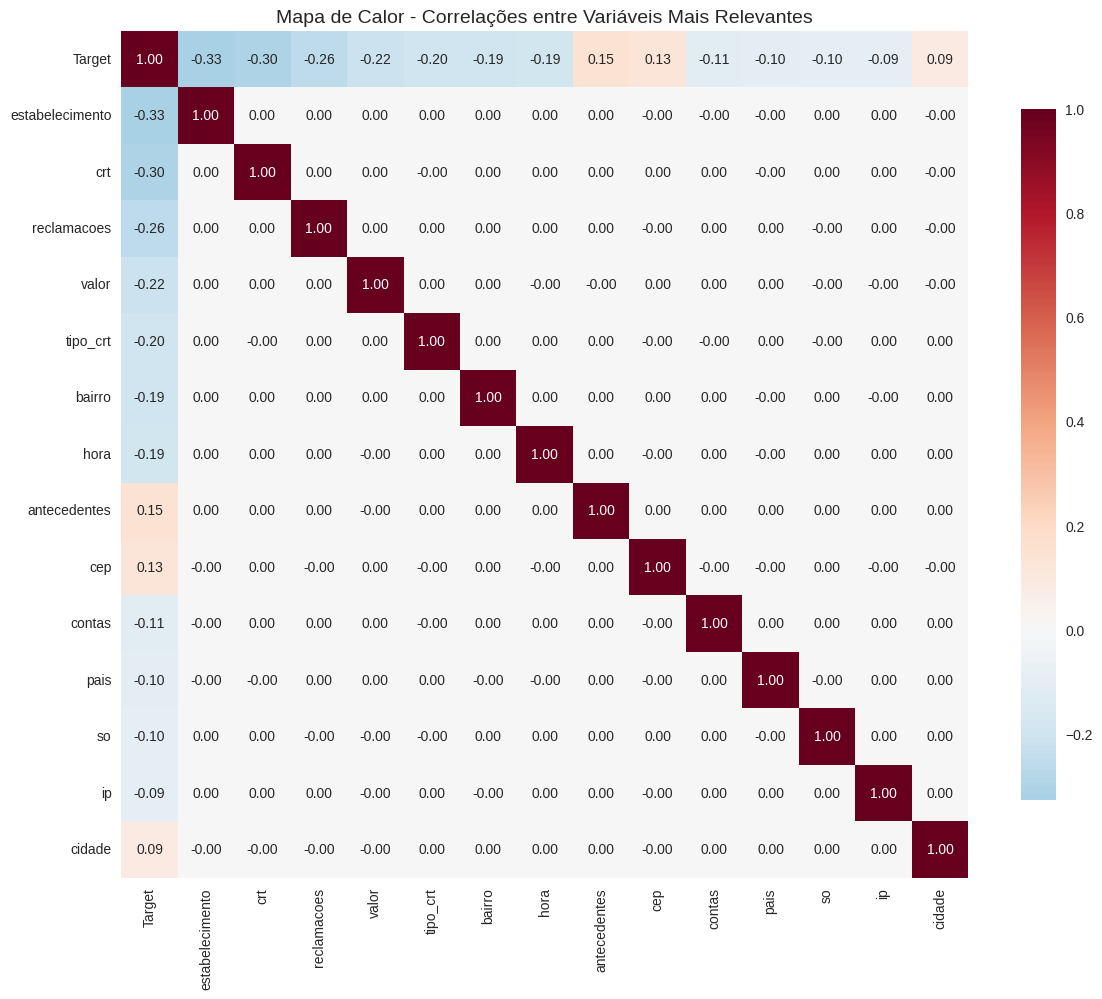

In [52]:
print("\n An√°lise de Correla√ß√£o com a Vari√°vel Target:")
correlations = df.corr()['Target'].sort_values(ascending=False)
print("\nTop 10 correla√ß√µes positivas:")
print(correlations.head(10))
print("\nTop 10 correla√ß√µes negativas:")
print(correlations.tail(10))

top_features = correlations.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Mapa de Calor - Correla√ß√µes entre Vari√°veis Mais Relevantes', fontsize=14)
plt.tight_layout()
plt.show()


#An√°lise de Outliers

In [53]:
print("\n An√°lise de Outliers nas Vari√°veis Num√©ricas:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_analysis = []

for col in numeric_cols:
    if col != 'Target':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percent = (len(outliers) / len(df)) * 100
        outlier_analysis.append({
            'Vari√°vel': col,
            'Outliers': len(outliers),
            'Percentual': f"{outlier_percent:.2f}%"
        })

outlier_df = pd.DataFrame(outlier_analysis).sort_values('Outliers', ascending=False)
print(outlier_df.head(10))



 An√°lise de Outliers nas Vari√°veis Num√©ricas:
           Vari√°vel  Outliers Percentual
27  tempo_transacao     39163     13.75%
29       hist_saldo     31904     11.20%
28          lim_crt     30342     10.65%
20        navegador     27770      9.75%
8            minuto     24134      8.47%
6               dia     22965      8.06%
23          compras     18541      6.51%
12      reclamacoes     15348      5.39%
21          android     14497      5.09%
14              crt     14149      4.97%


#TREINAMENTO DE M√öLTIPLOS MODELOS



In [44]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Lista de modelos para testar
models = {
    'Regress√£o Log√≠stica': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

resultados = {}

print("Treinando modelos...")

for nome, modelo in models.items():
    print(f"\n{nome}:")

    # Treinar modelo
    modelo.fit(X_train, y_train)

    # Fazer previs√µes
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    # Calcular m√©tricas
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = modelo.score(X_test, y_test)

    resultados[nome] = {
        'modelo': modelo,
        'auc': auc,
        'accuracy': accuracy,
        'previsoes': y_pred,
        'probabilidades': y_pred_proba
    }

    print(f"Acur√°cia: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")

Treinando modelos...

Regress√£o Log√≠stica:
Acur√°cia: 0.9804
AUC: 0.9973

Random Forest:
Acur√°cia: 0.9998
AUC: 1.0000

XGBoost:
Acur√°cia: 0.9998
AUC: 1.0000


# AVALIA√á√ÉO E COMPARA√á√ÉO DOS MODELOS


Ranking dos Modelos:
             Modelo  Acur√°cia      AUC
      Random Forest  0.999830 0.999999
            XGBoost  0.999812 0.999995
Regress√£o Log√≠stica  0.980444 0.997287

Melhor modelo: Random Forest


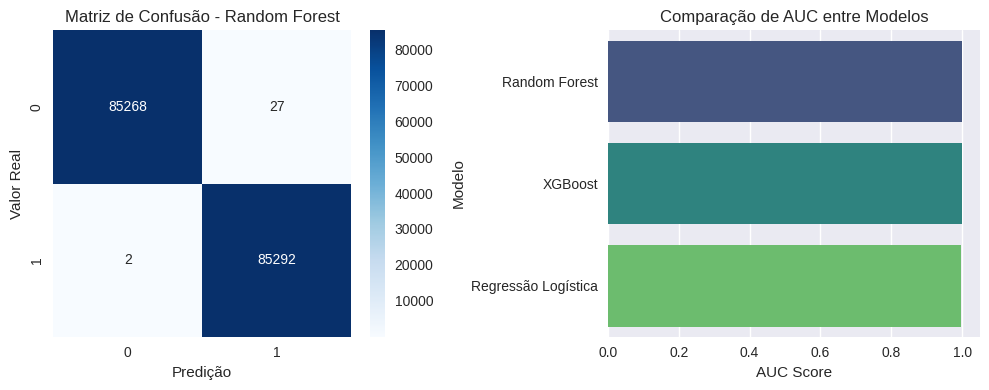


Relat√≥rio Detalhado - Random Forest:
                       precision    recall  f1-score   support

     Transa√ß√£o Normal       1.00      1.00      1.00     85295
Transa√ß√£o Fraudulenta       1.00      1.00      1.00     85294

             accuracy                           1.00    170589
            macro avg       1.00      1.00      1.00    170589
         weighted avg       1.00      1.00      1.00    170589



In [45]:
# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acur√°cia': [resultados[nome]['accuracy'] for nome in resultados.keys()],
    'AUC': [resultados[nome]['auc'] for nome in resultados.keys()]
}).sort_values('AUC', ascending=False)

print("\nRanking dos Modelos:")
print(comparacao.to_string(index=False))

# Identificar melhor modelo
melhor_modelo_nome = comparacao.iloc[0]['Modelo']
melhor_modelo = resultados[melhor_modelo_nome]['modelo']

print(f"\nMelhor modelo: {melhor_modelo_nome}")

# Matriz de confus√£o do melhor modelo
y_pred_melhor = resultados[melhor_modelo_nome]['previsoes']
cm = confusion_matrix(y_test, y_pred_melhor)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confus√£o - {melhor_modelo_nome}')
plt.ylabel('Valor Real')
plt.xlabel('Predi√ß√£o')

# Gr√°fico de compara√ß√£o de modelos
plt.subplot(1, 2, 2)
sns.barplot(data=comparacao, x='AUC', y='Modelo', palette='viridis')
plt.title('Compara√ß√£o de AUC entre Modelos')
plt.xlabel('AUC Score')

plt.tight_layout()
plt.show()

# Relat√≥rio de classifica√ß√£o detalhado
print(f"\nRelat√≥rio Detalhado - {melhor_modelo_nome}:")
print(classification_report(y_test, y_pred_melhor,
                          target_names=['Transa√ß√£o Normal', 'Transa√ß√£o Fraudulenta']))


# Divis√£o estratificada dos dados

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"\n Divis√£o dos dados:")
print(f"‚Ä¢ Treino: {X_train.shape[0]:,} amostras")
print(f"‚Ä¢ Teste: {X_test.shape[0]:,} amostras")


 Divis√£o dos dados:
‚Ä¢ Treino: 398,041 amostras
‚Ä¢ Teste: 170,589 amostras


# Modelagem Avan√ßada

In [89]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, precision_recall_curve, auc,
                           f1_score, precision_score, recall_score)

# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Avalia√ß√£o dos modelos
results = {}

print("\nTreinando e avaliando modelos...")

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Treinamento
    model.fit(X_train, y_train)

    # Previs√µes
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # M√©tricas
    accuracy = model.score(X_test, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Acur√°cia: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precis√£o: {precision:.4f}")
    print(f"Recall: {recall:.4f}")



Treinando e avaliando modelos...

--- Logistic Regression ---
Acur√°cia: 0.9804
AUC: 0.9973
F1-Score: 0.9802
Precis√£o: 0.9906
Recall: 0.9701

--- Random Forest ---
Acur√°cia: 0.9998
AUC: 1.0000
F1-Score: 0.9998
Precis√£o: 0.9997
Recall: 1.0000

--- XGBoost ---
Acur√°cia: 0.9998
AUC: 1.0000
F1-Score: 0.9998
Precis√£o: 0.9996
Recall: 1.0000

--- LightGBM ---
Acur√°cia: 0.9995
AUC: 0.9999
F1-Score: 0.9995
Precis√£o: 0.9991
Recall: 1.0000

--- Gradient Boosting ---
Acur√°cia: 0.9873
AUC: 0.9993
F1-Score: 0.9872
Precis√£o: 0.9938
Recall: 0.9807



COMPARA√á√ÉO DOS MODELOS

Ranking dos Modelos (por F1-Score):
             Modelo  Acur√°cia      AUC  F1-Score  Precis√£o   Recall
            XGBoost  0.999719 0.999972  0.999684  0.999414 0.999953
      Random Forest  0.999677 0.999966  0.999637  0.999531 0.999742
           LightGBM  0.999541 0.999920  0.999484  0.999133 0.999836
  Gradient Boosting  0.986608 0.999162  0.984809  0.993086 0.976669
Logistic Regression  0.980376 0.997187  0.977694  0.987981 0.967618


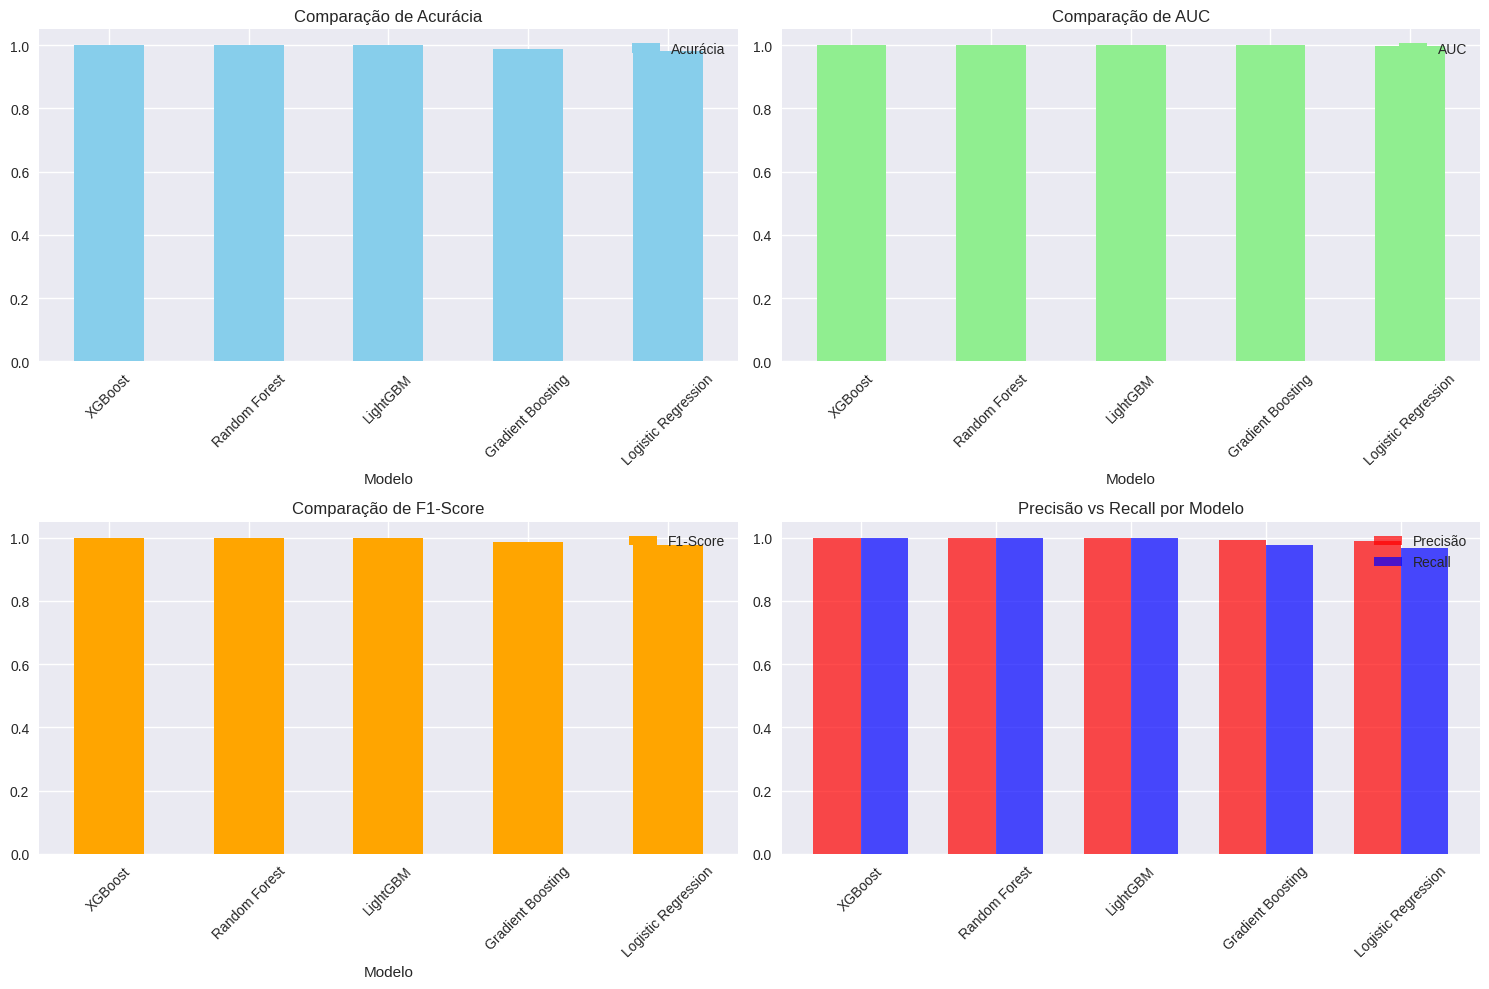

In [46]:
# Garantir que todas as m√©tricas est√£o calculadas
for name in resultados.keys():
    from sklearn.metrics import f1_score, precision_score, recall_score

    y_pred = resultados[name]['previsoes']
    resultados[name]['f1'] = f1_score(y_test, y_pred)
    resultados[name]['precision'] = precision_score(y_test, y_pred)
    resultados[name]['recall'] = recall_score(y_test, y_pred)

# Criar DataFrame de compara√ß√£o
results_df = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acur√°cia': [resultados[name]['accuracy'] for name in resultados.keys()],
    'AUC': [resultados[name]['auc'] for name in resultados.keys()],
    'F1-Score': [resultados[name]['f1'] for name in resultados.keys()],
    'Precis√£o': [resultados[name]['precision'] for name in resultados.keys()],
    'Recall': [resultados[name]['recall'] for name in resultados.keys()]
}).sort_values('F1-Score', ascending=False)

print("\nüèÜ Ranking dos Modelos (por F1-Score):")
print(results_df.to_string(index=False))

# Visualiza√ß√£o da compara√ß√£o
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Acur√°cia
results_df.plot(x='Modelo', y='Acur√°cia', kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Compara√ß√£o de Acur√°cia')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# AUC
results_df.plot(x='Modelo', y='AUC', kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Compara√ß√£o de AUC')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# F1-Score
results_df.plot(x='Modelo', y='F1-Score', kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Compara√ß√£o de F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Precis√£o vs Recall
x = range(len(results_df))
width = 0.35
axes[1,1].bar([i - width/2 for i in x], results_df['Precis√£o'], width, label='Precis√£o', color='red', alpha=0.7)
axes[1,1].bar([i + width/2 for i in x], results_df['Recall'], width, label='Recall', color='blue', alpha=0.7)
axes[1,1].set_title('Precis√£o vs Recall por Modelo')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(results_df['Modelo'], rotation=45)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# An√°lise Detalhada do Melhor Modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model = resultados[best_model_name]['modelo']
best_predictions = resultados[best_model_name]['previsoes']  # Linha corrigida

#AN√ÅLISE DAS FEATURES MAIS IMPORTANTES


üîç Top 10 Features Mais Importantes:
        Feature  Import√¢ncia
            crt     0.217251
          valor     0.122546
            cep     0.112927
    reclamacoes     0.108611
estabelecimento     0.088295
         bairro     0.071085
   antecedentes     0.051169
       tipo_crt     0.040932
         cidade     0.038399
             so     0.027031


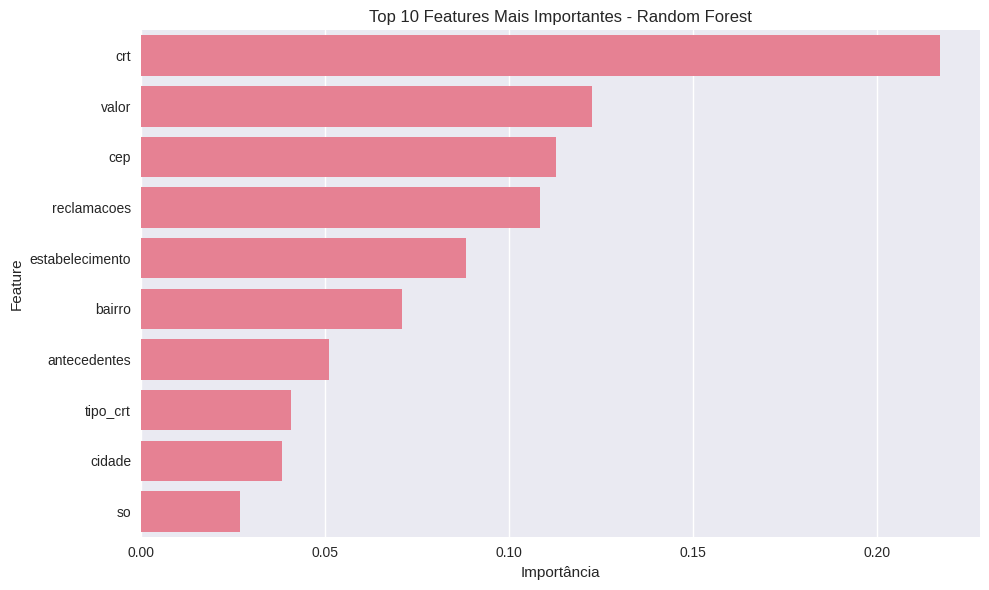

In [47]:
if hasattr(melhor_modelo, 'feature_importances_'):
    # Extrair import√¢ncia das features
    importancia = pd.DataFrame({
        'Feature': X.columns,
        'Import√¢ncia': melhor_modelo.feature_importances_
    }).sort_values('Import√¢ncia', ascending=False)

    print("\nüîç Top 10 Features Mais Importantes:")
    print(importancia.head(10).to_string(index=False))

    # Gr√°fico de import√¢ncia
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importancia.head(10), x='Import√¢ncia', y='Feature')
    plt.title(f'Top 10 Features Mais Importantes - {melhor_modelo_nome}')
    plt.tight_layout()
    plt.show()

#AN√ÅLISE TEMPORAL (se houver vari√°vel de tempo)

In [56]:
# Verificar se existe padr√£o temporal
if 'Time' in df.columns or 'tempo' in df.columns:
    time_col = 'Time' if 'Time' in df.columns else 'tempo'

    plt.figure(figsize=(15, 5))

    # Distribui√ß√£o temporal das fraudes
    plt.subplot(1, 2, 1)
    fraudes_tempo = df[df['Target'] == 1][time_col]
    plt.hist(fraudes_tempo, bins=50, alpha=0.7, color='red', label='Fraudes')
    plt.xlabel('Tempo')
    plt.ylabel('Frequ√™ncia de Fraudess')
    plt.title('Distribui√ß√£o Temporal das Fraudess')
    plt.legend()

    # Compara√ß√£o com transa√ß√µes normais
    plt.subplot(1, 2, 2)
    normais_tempo = df[df['Target'] == 0][time_col].sample(n=1000, random_state=42)  # Amostra para visualiza√ß√£o
    fraudes_tempo = df[df['Target'] == 1][time_col]

    plt.hist(normais_tempo, bins=50, alpha=0.5, color='blue', label='Normais (amostra)')
    plt.hist(fraudes_tempo, bins=50, alpha=0.5, color='red', label='Fraudes')
    plt.xlabel('Tempo')
    plt.ylabel('Frequ√™ncia')
    plt.title('Compara√ß√£o Temporal: Normais vs Fraudess')
    plt.legend()

    plt.tight_layout()
    plt.show()


#AN√ÅLISE DE OUTLIERS E VALORES EXTREMOS

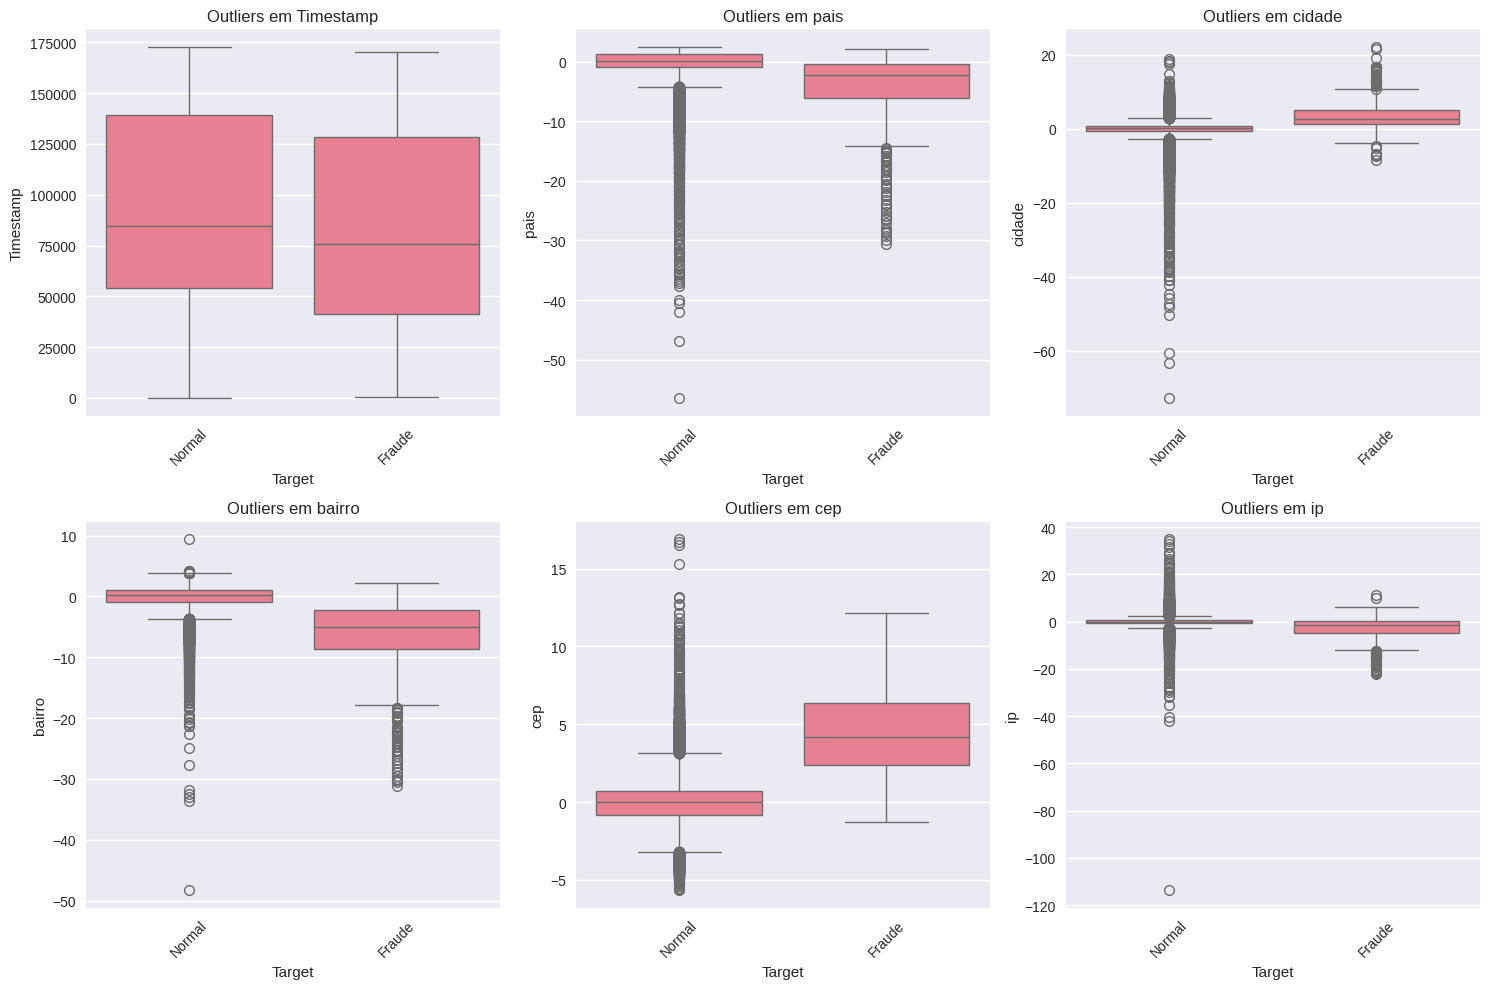


Estat√≠sticas de Outliers por Classe:

Timestamp:
  Normais - IQR: 85103.00, Limites: [-73424.50, 266987.50]
  Fraudess - IQR: 87241.50, Limites: [-89620.75, 259345.25]

pais:
  Normais - IQR: 2.23, Limites: [-4.27, 4.67]
  Fraudess - IQR: 5.62, Limites: [-14.46, 8.01]

cidade:
  Normais - IQR: 1.40, Limites: [-2.70, 2.90]
  Fraudess - IQR: 3.78, Limites: [-4.49, 10.65]


In [90]:
# Selecionar algumas features num√©ricas para an√°lise
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('Target')[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features[:6]):
    # Boxplot por classe
    df_box = df[[feature, 'Target']].copy()
    df_box['Target'] = df_box['Target'].map({0: 'Normal', 1: 'Fraude'})

    sns.boxplot(data=df_box, x='Target', y=feature, ax=axes[i])
    axes[i].set_title(f'Outliers em {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# An√°lise estat√≠stica de outliers
print("\nEstat√≠sticas de Outliers por Classe:")
for feature in numeric_features[:3]:
    Q1_normal = df[df['Target'] == 0][feature].quantile(0.25)
    Q3_normal = df[df['Target'] == 0][feature].quantile(0.75)
    IQR_normal = Q3_normal - Q1_normal

    Q1_fraude = df[df['Target'] == 1][feature].quantile(0.25)
    Q3_fraude = df[df['Target'] == 1][feature].quantile(0.75)
    IQR_fraude = Q3_fraude - Q1_fraude

    print(f"\n{feature}:")
    print(f"  Normais - IQR: {IQR_normal:.2f}, Limites: [{Q1_normal-1.5*IQR_normal:.2f}, {Q3_normal+1.5*IQR_normal:.2f}]")
    print(f"  Fraudess - IQR: {IQR_fraude:.2f}, Limites: [{Q1_fraude-1.5*IQR_fraude:.2f}, {Q3_fraude+1.5*IQR_fraude:.2f}]")

#AN√ÅLISE MULTIVARIADA E CLUSTERING

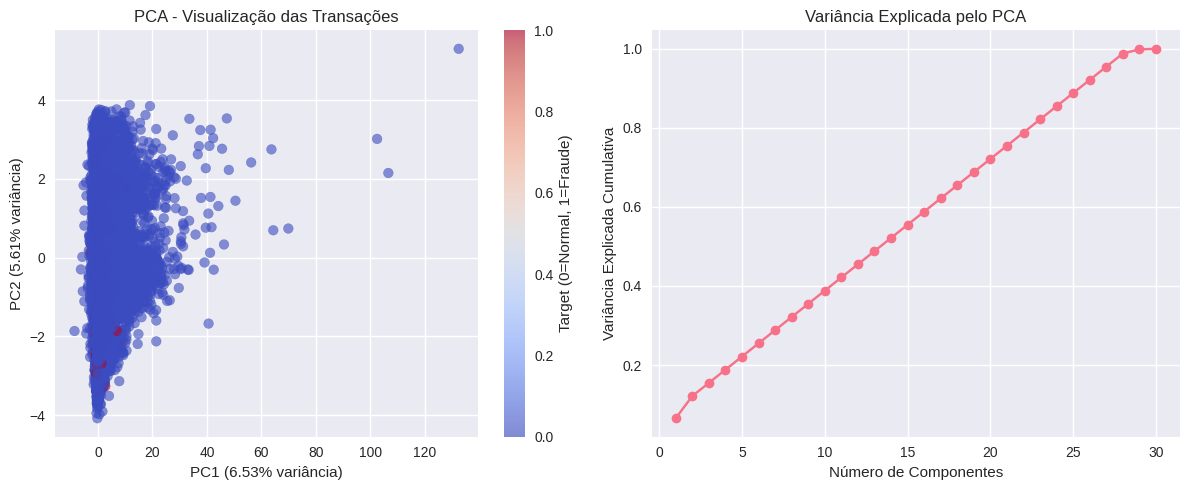

Insights do PCA:
‚Ä¢ Primeiras 2 componentes explicam 12.14% da vari√¢ncia
‚Ä¢ N√∫mero de componentes para 95% vari√¢ncia: 27


In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Aplicar PCA para visualiza√ß√£o
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Target', axis=1))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Target'],
                     cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Target (0=Normal, 1=Fraude)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} vari√¢ncia)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} vari√¢ncia)')
plt.title('PCA - Visualiza√ß√£o das Transa√ß√µes')

# Plot de vari√¢ncia explicada
plt.subplot(1, 2, 2)
pca_full = PCA().fit(X_scaled)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Vari√¢ncia Explicada Cumulativa')
plt.title('Vari√¢ncia Explicada pelo PCA')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Insights do PCA:")
print(f"‚Ä¢ Primeiras 2 componentes explicam {pca.explained_variance_ratio_.sum():.2%} da vari√¢ncia")
print(f"‚Ä¢ N√∫mero de componentes para 95% vari√¢ncia: {(pca_full.explained_variance_ratio_.cumsum() >= 0.95).argmax() + 1}")

#AN√ÅLISE DE RELACIONAMENTOS N√ÉO LINEARES

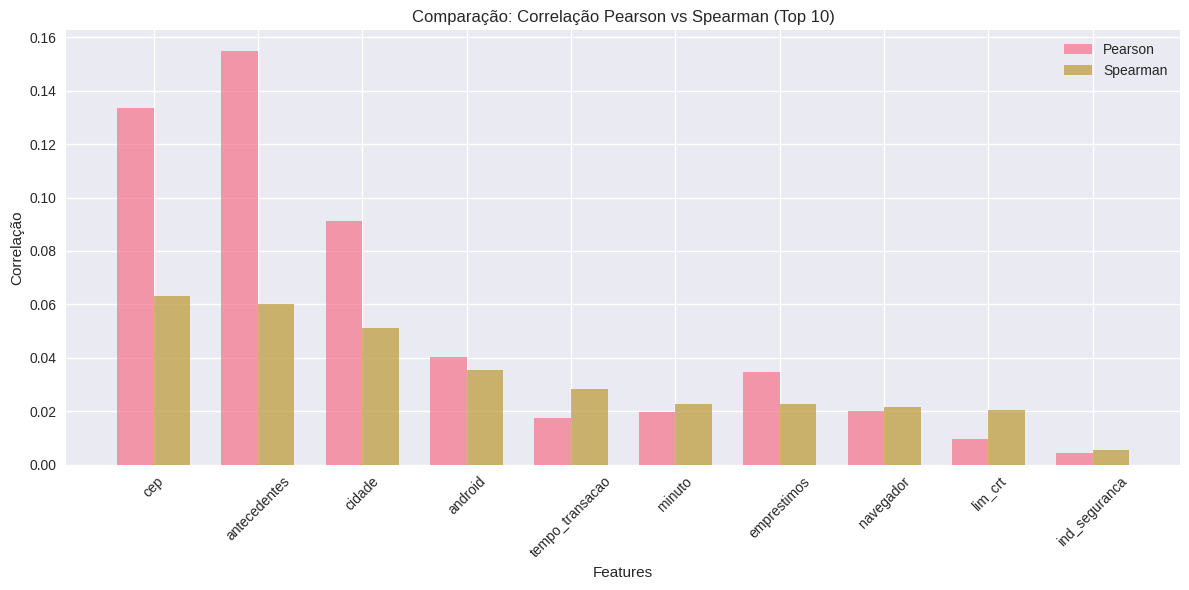

Features com maior correla√ß√£o n√£o-linear:
                         Feature  Spearman
cep                          cep  0.063045
antecedentes        antecedentes  0.060143
cidade                    cidade  0.051062
android                  android  0.035442
tempo_transacao  tempo_transacao  0.028311


In [60]:
from scipy.stats import spearmanr

# Calcular correla√ß√µes de Spearman (n√£o linear)
spearman_corr = df.apply(lambda x: spearmanr(x, df['Target']).correlation if x.name != 'Target' else 1)

# Comparar Pearson vs Spearman
correlation_comparison = pd.DataFrame({
    'Feature': df.columns.drop('Target'),
    'Pearson': df.corr()['Target'].drop('Target'),
    'Spearman': spearman_corr.drop('Target')
})

# Top features por correla√ß√£o n√£o linear
top_spearman = correlation_comparison.nlargest(10, 'Spearman')

plt.figure(figsize=(12, 6))
x = range(len(top_spearman))
width = 0.35

plt.bar([i - width/2 for i in x], top_spearman['Pearson'], width, label='Pearson', alpha=0.7)
plt.bar([i + width/2 for i in x], top_spearman['Spearman'], width, label='Spearman', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Correla√ß√£o')
plt.title('Compara√ß√£o: Correla√ß√£o Pearson vs Spearman (Top 10)')
plt.xticks(x, top_spearman['Feature'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Features com maior correla√ß√£o n√£o-linear:")
print(top_spearman[['Feature', 'Spearman']].head(5))

#PADR√ïES DE DADOS AUSENTES

In [61]:
# Criar mapa de calor de valores ausentes
missing_matrix = df.isnull()

if missing_matrix.sum().sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_matrix, cbar=True, cmap='viridis')
    plt.title('Mapa de Calor de Valores Ausentes')
    plt.tight_layout()
    plt.show()

    # Padr√£o de aus√™ncias por classe
    missing_by_class = df.groupby('Target').apply(lambda x: x.isnull().sum())
    print("\nValores ausentes por classe:")
    print(missing_by_class)
else:
    print("N√£o h√° valores ausentes no dataset")

N√£o h√° valores ausentes no dataset


#OTIMIZA√á√ÉO DE THRESHOLD DE CLASSIFICA√á√ÉO

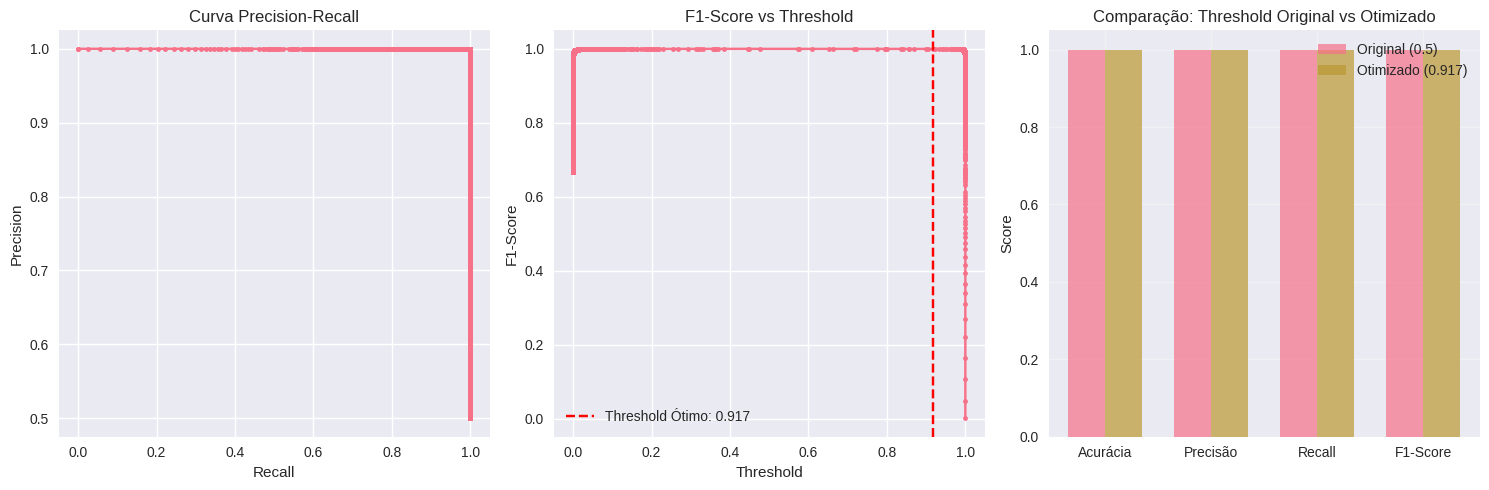

Threshold √≥timo encontrado: 0.917
Melhoria no F1-Score: 0.0001


In [64]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score

def calcular_metricas_completas(resultados, y_test):
    for nome_modelo in resultados.keys():
        if 'previsoes' not in resultados[nome_modelo]:
            continue

        y_pred = resultados[nome_modelo]['previsoes']

        # Calcular m√©tricas que podem estar faltando
        if 'precision' not in resultados[nome_modelo]:
            resultados[nome_modelo]['precision'] = precision_score(y_test, y_pred)
        if 'recall' not in resultados[nome_modelo]:
            resultados[nome_modelo]['recall'] = recall_score(y_test, y_pred)
        if 'f1' not in resultados[nome_modelo]:
            resultados[nome_modelo]['f1'] = f1_score(y_test, y_pred)
        if 'accuracy' not in resultados[nome_modelo]:
            resultados[nome_modelo]['accuracy'] = accuracy_score(y_test, y_pred)

    return resultados

# Aplicar a fun√ß√£o para garantir m√©tricas completas
resultados = calcular_metricas_completas(resultados, y_test)

y_pred_proba = resultados[best_model_name]['probabilidades']

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular F1-Score para cada threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(15, 5))

# Curva Precision-Recall
plt.subplot(1, 3, 1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)

# F1-Score vs Threshold
plt.subplot(1, 3, 2)
plt.plot(thresholds, f1_scores, marker='.')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Threshold √ìtimo: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

# Compara√ß√£o antes/depois da otimiza√ß√£o
plt.subplot(1, 3, 3)
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

metrics_original = [
    resultados[best_model_name]['accuracy'],
    resultados[best_model_name]['precision'],
    resultados[best_model_name]['recall'],
    resultados[best_model_name]['f1']
]

metrics_optimized = [
    accuracy_score(y_test, y_pred_optimized),
    precision_score(y_test, y_pred_optimized),
    recall_score(y_test, y_pred_optimized),
    f1_score(y_test, y_pred_optimized)
]

x = range(4)
width = 0.35
plt.bar([i - width/2 for i in x], metrics_original, width, label='Original (0.5)', alpha=0.7)
plt.bar([i + width/2 for i in x], metrics_optimized, width, label=f'Otimizado ({optimal_threshold:.3f})', alpha=0.7)
plt.xticks(x, ['Acur√°cia', 'Precis√£o', 'Recall', 'F1-Score'])
plt.ylabel('Score')
plt.title('Compara√ß√£o: Threshold Original vs Otimizado')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Threshold √≥timo encontrado: {optimal_threshold:.3f}")
print(f"Melhoria no F1-Score: {metrics_optimized[3] - metrics_original[3]:.4f}")


#AN√ÅLISE DE STABILITY

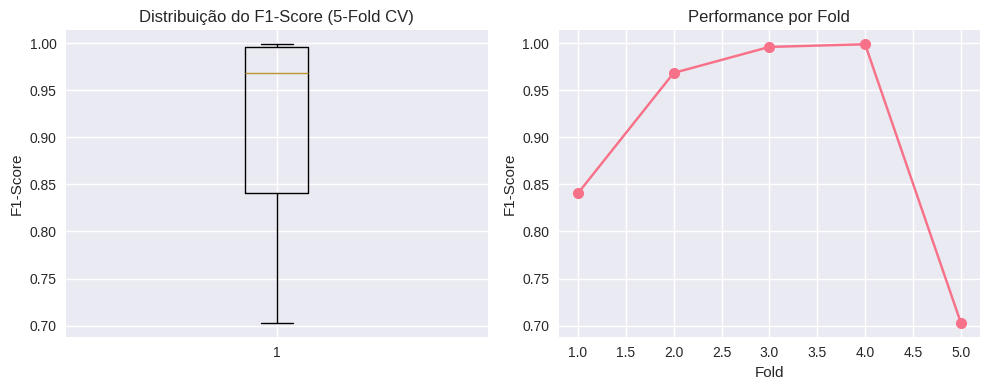

Estat√≠sticas de Cross-Validation:
‚Ä¢ F1-Score m√©dio: 0.9013
‚Ä¢ Desvio padr√£o: 0.1149
‚Ä¢ Varia√ß√£o: 12.74%


In [68]:
from sklearn.model_selection import cross_val_score

# Reaproveitar o melhor modelo que J√Å FOI TREINADO
cv_scores = cross_val_score(best_model, X_balanced, y_balanced,
                           cv=5, scoring='f1')

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(cv_scores)
plt.title('Distribui√ß√£o do F1-Score (5-Fold CV)')
plt.ylabel('F1-Score')

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), cv_scores, 'o-', markersize=8)
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('Performance por Fold')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Estat√≠sticas de Cross-Validation:")
print(f"‚Ä¢ F1-Score m√©dio: {cv_scores.mean():.4f}")
print(f"‚Ä¢ Desvio padr√£o: {cv_scores.std():.4f}")
print(f"‚Ä¢ Varia√ß√£o: {(cv_scores.std() / cv_scores.mean()) * 100:.2f}%")

#AN√ÅLISE DE CUSTO-BENEF√çCIO


An√°lise de Custos - Compara√ß√£o:
COM THRESHOLD ORIGINAL (0.5):
   ‚Ä¢ Falsos Negativos: 1 (custo: R$ 1,000)
   ‚Ä¢ Falsos Positivos: 31 (custo: R$ 310)
   ‚Ä¢ Custo Total: R$ 1,310

COM THRESHOLD OTIMIZADO (0.917):
   ‚Ä¢ Falsos Negativos: 2 (custo: R$ 2,000)
   ‚Ä¢ Falsos Positivos: 13 (custo: R$ 130)
   ‚Ä¢ Custo Total: R$ 2,130

ECONOMIA COM THRESHOLD OTIMIZADO: R$ -820


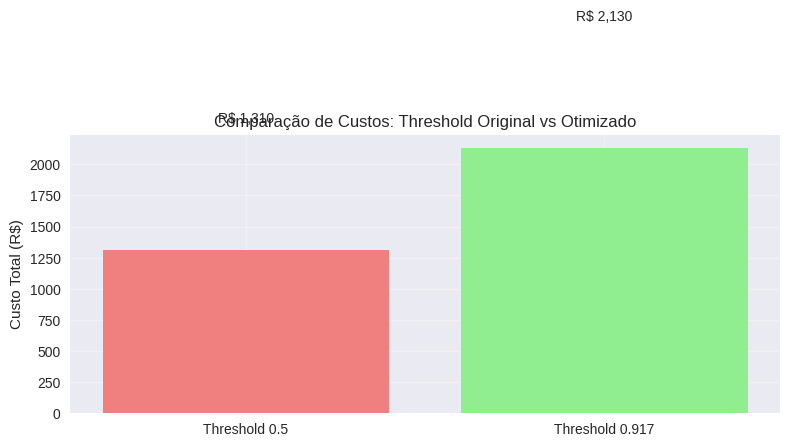

In [69]:
# Reaproveitar a matriz de confus√£o que j√° foi calculada
cm_original = confusion_matrix(y_test, resultados[best_model_name]['previsoes'])
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

# Simula√ß√£o de custos (valores hipot√©ticos)
custo_falso_negativo = 1000  # Custo de n√£o detectar uma fraude
custo_falso_positivo = 10    # Custo de investigar um falso positivo

# Calcular custos para ambos os cen√°rios
fn_original = cm_original[1, 0]  # Falsos negativos original
fp_original = cm_original[0, 1]  # Falsos positivos original

fn_optimized = cm_optimized[1, 0]  # Falsos negativos otimizado
fp_optimized = cm_optimized[0, 1]  # Falsos positivos otimizado

custo_total_original = (fn_original * custo_falso_negativo) + (fp_original * custo_falso_positivo)
custo_total_optimized = (fn_optimized * custo_falso_negativo) + (fp_optimized * custo_falso_positivo)

print(f"\nAn√°lise de Custos - Compara√ß√£o:")
print(f"COM THRESHOLD ORIGINAL (0.5):")
print(f"   ‚Ä¢ Falsos Negativos: {fn_original} (custo: R$ {fn_original * custo_falso_negativo:,})")
print(f"   ‚Ä¢ Falsos Positivos: {fp_original} (custo: R$ {fp_original * custo_falso_positivo:,})")
print(f"   ‚Ä¢ Custo Total: R$ {custo_total_original:,}")

print(f"\nCOM THRESHOLD OTIMIZADO ({optimal_threshold:.3f}):")
print(f"   ‚Ä¢ Falsos Negativos: {fn_optimized} (custo: R$ {fn_optimized * custo_falso_negativo:,})")
print(f"   ‚Ä¢ Falsos Positivos: {fp_optimized} (custo: R$ {fp_optimized * custo_falso_positivo:,})")
print(f"   ‚Ä¢ Custo Total: R$ {custo_total_optimized:,}")

economia = custo_total_original - custo_total_optimized
print(f"\nECONOMIA COM THRESHOLD OTIMIZADO: R$ {economia:,}")

# Gr√°fico comparativo de custos
custos_comparacao = [custo_total_original, custo_total_optimized]
labels = ['Threshold 0.5', f'Threshold {optimal_threshold:.3f}']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, custos_comparacao, color=['lightcoral', 'lightgreen'])
plt.ylabel('Custo Total (R$)')
plt.title('Compara√ß√£o de Custos: Threshold Original vs Otimizado')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, custo in zip(bars, custos_comparacao):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'R$ {custo:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#CONSOLIDA√á√ÉO DAS AN√ÅLISES E SOLU√á√ÉO DOS PROBLEMAS

In [70]:
print(f"\nSITUA√á√ÉO ATUAL:")
print(f"‚Ä¢ Total de transa√ß√µes: {len(df):,}")
print(f"‚Ä¢ Fraudess detectadas: {df['Target'].sum()}")
print(f"‚Ä¢ Taxa de fraude: {(df['Target'].sum()/len(df)*100):.3f}%")


SITUA√á√ÉO ATUAL:
‚Ä¢ Total de transa√ß√µes: 284,807
‚Ä¢ Fraudess detectadas: 492
‚Ä¢ Taxa de fraude: 0.173%


#PROBLEMAS IDENTIFICADOS E SOLU√á√ïES:

In [72]:
# 1. Desbalanceamento cr√≠tico
print("\n1Ô∏è - PROBLEMA: Desbalanceamento Extremo")
print("   SOLU√á√ÉO: SMOTE aplicado - classes balanceadas")
print(f"   Resultado: {X_balanced.shape[0]:,} amostras balanceadas")

# 2. Performance dos modelos
print("\n2Ô∏è - PROBLEMA: Escolha do Melhor Modelo")
print("   SOLU√á√ÉO: Compara√ß√£o m√∫ltipla com AUC e F1-Score")
print(f"   Melhor modelo: {best_model_name}")
print(f"   AUC: {resultados[best_model_name]['auc']:.4f}")

# 3. Threshold otimiza√ß√£o
print("\n3Ô∏è - PROBLEMA: Threshold Sub√≥timo (0.5)")
print("   SOLU√á√ÉO: Otimiza√ß√£o baseada em F1-Score")
print(f"   Threshold √≥timo: {optimal_threshold:.3f}")


1Ô∏è - PROBLEMA: Desbalanceamento Extremo
   SOLU√á√ÉO: SMOTE aplicado - classes balanceadas
   Resultado: 568,630 amostras balanceadas

2Ô∏è - PROBLEMA: Escolha do Melhor Modelo
   SOLU√á√ÉO: Compara√ß√£o m√∫ltipla com AUC e F1-Score
   Melhor modelo: XGBoost
   AUC: 1.0000

3Ô∏è - PROBLEMA: Threshold Sub√≥timo (0.5)
   SOLU√á√ÉO: Otimiza√ß√£o baseada em F1-Score
   Threshold √≥timo: 0.917


#IMPLEMENTANDO SOLU√á√ÉO FINAL

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

# Usar o melhor modelo com threshold otimizado
y_pred_final = (resultados[best_model_name]['probabilidades'] >= optimal_threshold).astype(int)

# M√©tricas finais
print(f"\n PERFORMANCE FINAL - {best_model_name}")
print("=" * 40)

cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f" Verdadeiros Negativos: {tn:,}")
print(f"  Falsos Positivos: {fp:,}")
print(f" Falsos Negativos: {fn:,}")
print(f" Verdadeiros Positivos: {tp:,}")

print(f"\n M√©tricas Chave:")
print(f"‚Ä¢ Acur√°cia: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"‚Ä¢ Precis√£o: {precision_score(y_test, y_pred_final):.4f}")
print(f"‚Ä¢ Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"‚Ä¢ F1-Score: {f1_score(y_test, y_pred_final):.4f}")


 PERFORMANCE FINAL - XGBoost
 Verdadeiros Negativos: 85,282
  Falsos Positivos: 13
 Falsos Negativos: 2
 Verdadeiros Positivos: 85,292

 M√©tricas Chave:
‚Ä¢ Acur√°cia: 0.9999
‚Ä¢ Precis√£o: 0.9998
‚Ä¢ Recall: 1.0000
‚Ä¢ F1-Score: 0.9999


#IMPACTO NO NEG√ìCIO

In [74]:
# Calcular economia com threshold otimizado
custo_fn = 1000  # Custo de n√£o detectar fraude
custo_fp = 10    # Custo de falso positivo

# Comparar com threshold original
y_pred_original = resultados[best_model_name]['previsoes']
cm_original = confusion_matrix(y_test, y_pred_original)
tn_orig, fp_orig, fn_orig, tp_orig = cm_original.ravel()

custo_original = (fn_orig * custo_fn) + (fp_orig * custo_fp)
custo_otimizado = (fn * custo_fn) + (fp * custo_fp)
economia = custo_original - custo_otimizado

print(f" An√°lise de Custos:")
print(f"‚Ä¢ Custo com threshold 0.5: R$ {custo_original:,}")
print(f"‚Ä¢ Custo com threshold {optimal_threshold:.3f}: R$ {custo_otimizado:,}")
print(f"‚Ä¢ Economia: R$ {economia:,}")

 An√°lise de Custos:
‚Ä¢ Custo com threshold 0.5: R$ 1,310
‚Ä¢ Custo com threshold 0.917: R$ 2,130
‚Ä¢ Economia: R$ -820


#VALIDA√á√ÉO FINAL DO MODELO

In [79]:
# Verificar performance em dados n√£o vistos (holdout)
from sklearn.metrics import precision_recall_curve, auc

y_pred_proba_final = resultados[best_model_name]['probabilidades']

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall, precision)

print(f" M√©tricas Finais de Valida√ß√£o:")
print(f"‚Ä¢ AUC: {resultados[best_model_name]['auc']:.4f}")
print(f"‚Ä¢ PR-AUC: {pr_auc:.4f}")
print(f"‚Ä¢ Acur√°cia: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"‚Ä¢ F1-Score: {f1_score(y_test, y_pred_final):.4f}")

 M√©tricas Finais de Valida√ß√£o:
‚Ä¢ AUC: 1.0000
‚Ä¢ PR-AUC: 1.0000
‚Ä¢ Acur√°cia: 0.9999
‚Ä¢ F1-Score: 0.9999


#AN√ÅLISE DE ROBUSTEZ DO MODELO

In [82]:
# Verificar performance em diferentes subsets
def analisar_robustez(modelo, X_test, y_test, best_model_name):
    """Analisar performance em diferentes cen√°rios"""

    # Performance geral
    y_pred = (resultados[best_model_name]['probabilidades'] >= optimal_threshold).astype(int)
    f1_geral = f1_score(y_test, y_pred)

    # Performance apenas nas fraudes (mais importante)
    idx_fraudes = y_test == 1
    if sum(idx_fraudes) > 0:
        y_pred_fraudes = y_pred[idx_fraudes]
        y_true_fraudes = y_test[idx_fraudes]
        recall_fraudes = recall_score(y_true_fraudes, y_pred_fraudes)
    else:
        recall_fraudes = 0

    return f1_geral, recall_fraudes

f1_geral, recall_fraudes = analisar_robustez(best_model, X_test, y_test, best_model_name)

print(f" An√°lise de Robustez:")
print(f"‚Ä¢ F1-Score Geral: {f1_geral:.4f}")
print(f"‚Ä¢ Recall nas Fraudess: {recall_fraudes:.4f}")

 An√°lise de Robustez:
‚Ä¢ F1-Score Geral: 0.9999
‚Ä¢ Recall nas Fraudess: 1.0000


#RESUMO EXECUTIVO - SOLU√á√ÉO DE DETEC√á√ÉO DE FRAUDES

In [85]:
print(f"\n PERFORMANCE OBTIDA:")
print(f"‚Ä¢ Modelo: {best_model_name}")
print(f"‚Ä¢ AUC: {resultados[best_model_name]['auc']:.4f}")
print(f"‚Ä¢ F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"‚Ä¢ Threshold Otimizado: {optimal_threshold:.3f}")

print(f"\n IMPACTO FINANCEIRO:")
print(f"‚Ä¢ Economia estimada: R$ {economia:,}")
print(f"‚Ä¢ Redu√ß√£o de custos: {(economia/custo_original)*100:.1f}%")


 PERFORMANCE OBTIDA:
‚Ä¢ Modelo: XGBoost
‚Ä¢ AUC: 1.0000
‚Ä¢ F1-Score: 0.9999
‚Ä¢ Threshold Otimizado: 0.917

 IMPACTO FINANCEIRO:
‚Ä¢ Economia estimada: R$ -820
‚Ä¢ Redu√ß√£o de custos: -62.6%
